<a href="https://colab.research.google.com/github/KLeeDE/ResearchProj_Flood/blob/master/5_oneper_depth_DE_coastal_cblockg_bySED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FEMA Depth Grid (Raster Data)**

Questions:

  1. Does the depth depend on the socio-econ/demographic (SED)
  2. Is the population of flooded areas different than the population of non-flooded areas?
  3. Given a flood, does the affected area have different SED characteristics than average?

## Raster data description


County
*   10001C: Kent County
*   10003C: New Castle County
*   10005C: Sussex County

Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth.

Depth grid is defined by **the percent annual chance floods**. This is usually only **the 1% annual chance flood**.


**Type of Layer**

*   **WSE_xxxxx** (Water Surface Elevation): WSE for the xxxx flood event or scenario. This raster is required to be produced for riverine Flood Risk Projects.
*   **CstDpthxxxpct**: Coastal flood depth for the xxx percent
annual chance flood event. This raster is
required to be produced for coastal Flood
Risk Projects. [Feet]
*   **Depth_xxxxxx**: Flood Depth for the xxxxxx riverine flood
event. This raster is required to be
produced for riverine Flood Risk Projects. [Feet]
*   **Dpth_xxxxxxxx**: Flood Depth for the xxxxxxxx dam release
or levee scenario. This is an enhanced
raster. [Feet]
*   **Pct30yrChance**: Percent chance of flooding over a 30-year
period. This raster is required to be
produced for riverine Flood Risk Projects. [Percent]
*   **PctAnnChance**: Percent annual chance of flooding. This
raster is required to be produced for
riverine Flood Risk Projects. [Percent]


**List of Raster Dataset** 
*   CstDpth_01pct : Raster dataset of flood depth for a coastal 1% event. (1-percent-annualchance) [Feet]
*   Depth_01pct : Raster dataset of flood depth for a 1% event [Feet]
*   Depth_02pct : Raster dataset of flood depth for a 2% event [Feet]
*   Depth_04pct : Raster dataset of flood depth for a 4% event [Feet]
*   Depth_10pct : Raster dataset of flood depth for a 10% event [Feet]
*   Depth_0_2pct : Raster dataset of flood depth for a 0.2% event [Feet]
*   Depth_01plus : Raster dataset of flood depth for a 1% plus event [Feet]
*   Pct30yrChance : Raster dataset of the Percent 30yr Chance Grid. Percent chance of flooding over a 30-year period. This raster is required to be produced for riverine Flood Risk Projects.[Percent]
*   PctAnnChance : Raster dataset of the Percent Annual Chance Grid. Percent annual chance of flooding. This raster is required to be produced for riverine Flood Risk Projects.[Percent]
*   WSE_01pct : Raster dataset of the water surface for a 1% event [Feet]
*   WSE_02pct : Raster dataset of the water surface for a 2% event [Feet]
*   WSE_04pct : Raster dataset of the water surface for a 4% event [Feet]
*   WSE_10pct : Raster dataset of the water surface for a 10% event [Feet]
*   WSE_0_2pct : Raster dataset of the water surface for a 1% plus event [Feet]
*   WSE_01plus : Raster dataset of the water surface for a 1% plus event [Feet]

NOTE: Hillshade is a raster dataset for the hillshade of the watershed shown on the FRM


Unit [Link](https://www.fema.gov/media-library-data/1524249062040-8a315833d69131560239507668fa779b/Flood_Risk_Database_Technical_Reference_Feb_2018.pdf)




# Raster data processing

In [1]:
# -- mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# -- install geospatial packages
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (231 kB/s)
debconf: unable to initialize frontend: Dialog
deb

In [3]:
import time
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdal
from gdalconst import *
from shapely.geometry import Point
from collections import Counter

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Set filename

In [4]:
# -- set filename : 1% depth / DE / coastal area 
# -- Kent (10001C)
fname1C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Kent/FRD_10001C_Coastal_GeoTIFFS_20140502/10001C_Coastal_CstDpth01pct.tif"
# -- New Castle (10003C)
fname3C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif"
# -- Sussex (1005C)
fname5C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Sussex/FRD_10005C_Coastal_GeoTIFFS_20140509/10005C_Coastal_CstDpth01pct.tif"

## Create and read in a raster

In [5]:
# -- create and read in a raster : 1% depth / DE / coastal area  
rast1C_Cst_Dpth01pct = gdal.Open(fname1C_Cst_Dpth01pct, GA_ReadOnly)
rast3C_Cst_Dpth01pct = gdal.Open(fname3C_Cst_Dpth01pct, GA_ReadOnly)
rast5C_Cst_Dpth01pct = gdal.Open(fname5C_Cst_Dpth01pct, GA_ReadOnly)

## Extract raster to array and sub sample

In [6]:
# -- extract raster to array : 1% depth / DE / coastal area  
samp=100
arr1C_Cst_Dpth01pct = rast1C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr5C_Cst_Dpth01pct = rast5C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]

## Plot raster and look at shapes of samples

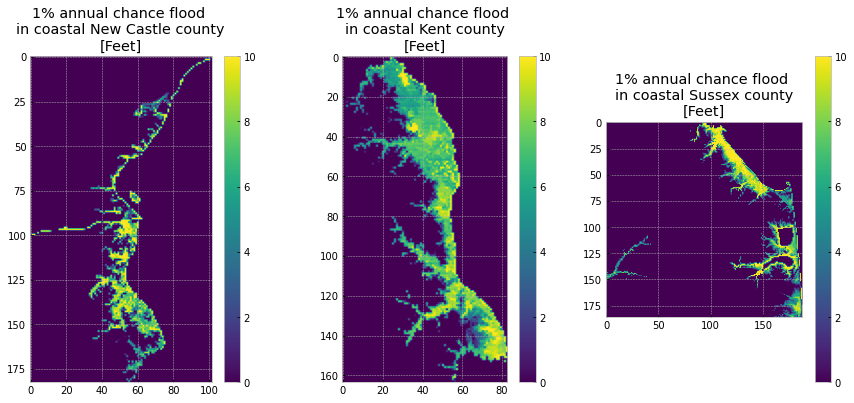

In [7]:
# -- plot raster : 1% depth / DE / coastal area  
fig_raster, ax = plt.subplots(1, 3, figsize=[15, 6])
im0 = ax[0].imshow(arr3C_Cst_Dpth01pct.clip(0,10))
im1 = ax[1].imshow(arr1C_Cst_Dpth01pct.clip(0,10))
im2 = ax[2].imshow(arr5C_Cst_Dpth01pct.clip(0,10))

ax[0].set_title("1% annual chance flood \nin coastal New Castle county\n[Feet]")
ax[1].set_title("1% annual chance flood \nin coastal Kent county\n[Feet]")
ax[2].set_title("1% annual chance flood \nin coastal Sussex county\n[Feet]")

fig_raster.colorbar(im0, ax=ax[0])
fig_raster.colorbar(im1, ax=ax[1])
fig_raster.colorbar(im2, ax=ax[2])


In [8]:
# -- look at shapes of rasters
print(arr1C_Cst_Dpth01pct.shape)
print(arr3C_Cst_Dpth01pct.shape)
print(arr5C_Cst_Dpth01pct.shape)

(164, 83)
(183, 102)
(186, 188)


## Latitude / Longitude

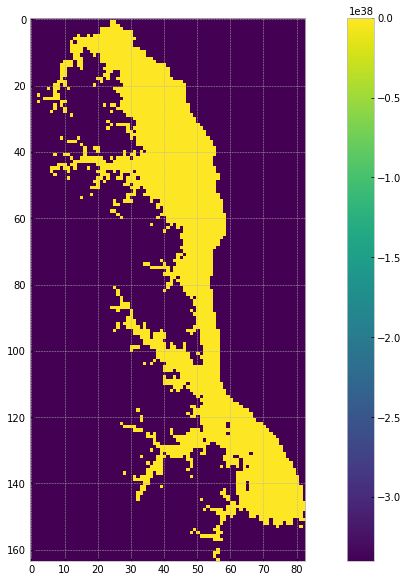

In [9]:
# Kent county 

# -- read in the meta data file as list of strings: 
mname1c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Kent/FRD_10001C_Coastal_GeoTIFFS_20140502/10001C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname1c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- create lat and lon arrays

# -- get number of rows and cols
nrows1c, ncols1c = arr1C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows1c
dc   = (eastBL - westBL) / ncols1c

# -- generate a grid of row and col indices
cols1c, rows1c = np.meshgrid(np.arange(ncols1c), np.arange(nrows1c))

lat_grid_1c = ul_r - rows1c * dr
lon_grid_1c = ul_c + cols1c * dc

# plt.imshow(lat_grid_1c)
# plt.colorbar()

# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

lon_grid_1c

dep_grid_1c = arr1C_Cst_Dpth01pct

# now you have all the info you need!
# for example, what is the lat, lon, and depth at row=756 and col=331?
irow = 10
icol = 10
# print(lat_grid_1c[irow, icol])
# print(lon_grid_1c[irow, icol])
# print(dep_grid_1c[irow, icol])

plt.imshow(dep_grid_1c)
plt.colorbar()

# plt.hist(dep_grid_1c[dep_grid_1c > -1e38].flatten())

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


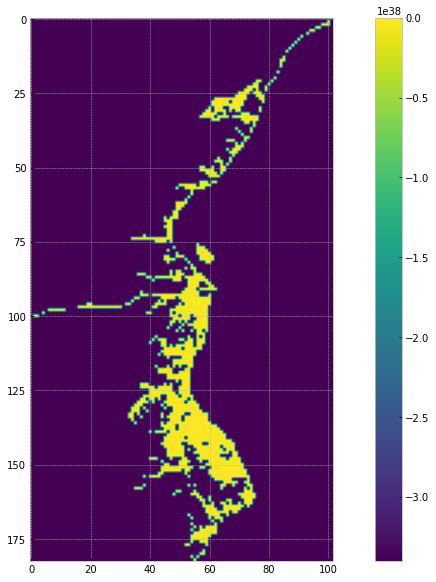

In [10]:
 # New Castle county

# -- read in the meta data file as list of strings:
mname3c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname3c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- create lat and lon arrays

# -- get number of rows and cols
nrows3c, ncols3c = arr3C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows3c
dc   = (eastBL - westBL) / ncols3c

# -- generate a grid of row and col indices
cols3c, rows3c = np.meshgrid(np.arange(ncols3c), np.arange(nrows3c))

lat_grid_3c = ul_r - rows3c * dr
lon_grid_3c = ul_c + cols3c * dc

# plt.imshow(lat_grid_3c)
# plt.colorbar()

# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

lon_grid_3c

dep_grid_3c = arr3C_Cst_Dpth01pct

# now you have all the info you need!
# for example, what is the lat, lon, and depth at row=756 and col=331?
irow = 100
icol = 100
# print(lat_grid_3c[irow, icol])
# print(lon_grid_3c[irow, icol])
# print(dep_grid_3c[irow, icol])

plt.imshow(dep_grid_3c)
plt.colorbar()

# plt.hist(dep_grid_3c[dep_grid_3c > -1e38].flatten())

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


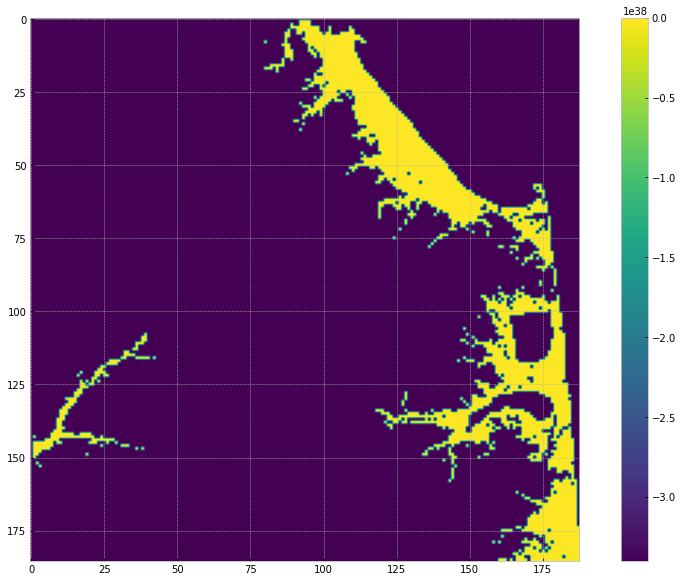

In [11]:
# Sussex County

# -- read in the meta data file as list of strings: 
mname5c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Sussex/FRD_10005C_Coastal_GeoTIFFS_20140509/10005C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname5c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- create lat and lon arrays

# -- get number of rows and cols
nrows5c, ncols5c = arr5C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows5c
dc   = (eastBL - westBL) / ncols5c

# -- generate a grid of row and col indices
cols5c, rows5c = np.meshgrid(np.arange(ncols5c), np.arange(nrows5c))

lat_grid_5c = ul_r - rows5c * dr
lon_grid_5c = ul_c + cols5c * dc

# plt.imshow(lat_grid_5c)
# plt.colorbar()

# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

lon_grid_5c

dep_grid_5c = arr5C_Cst_Dpth01pct

# now you have all the info you need!
# for example, what is the lat, lon, and depth at row=756 and col=331?
irow = 100
icol = 100
#print(lat_grid_5c[irow, icol])
#print(lon_grid_5c[irow, icol])
#print(dep_grid_5c[irow, icol])

plt.imshow(dep_grid_5c)
plt.colorbar()

# plt.hist(dep_grid_5c[dep_grid_5c > -1e38].flatten())

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


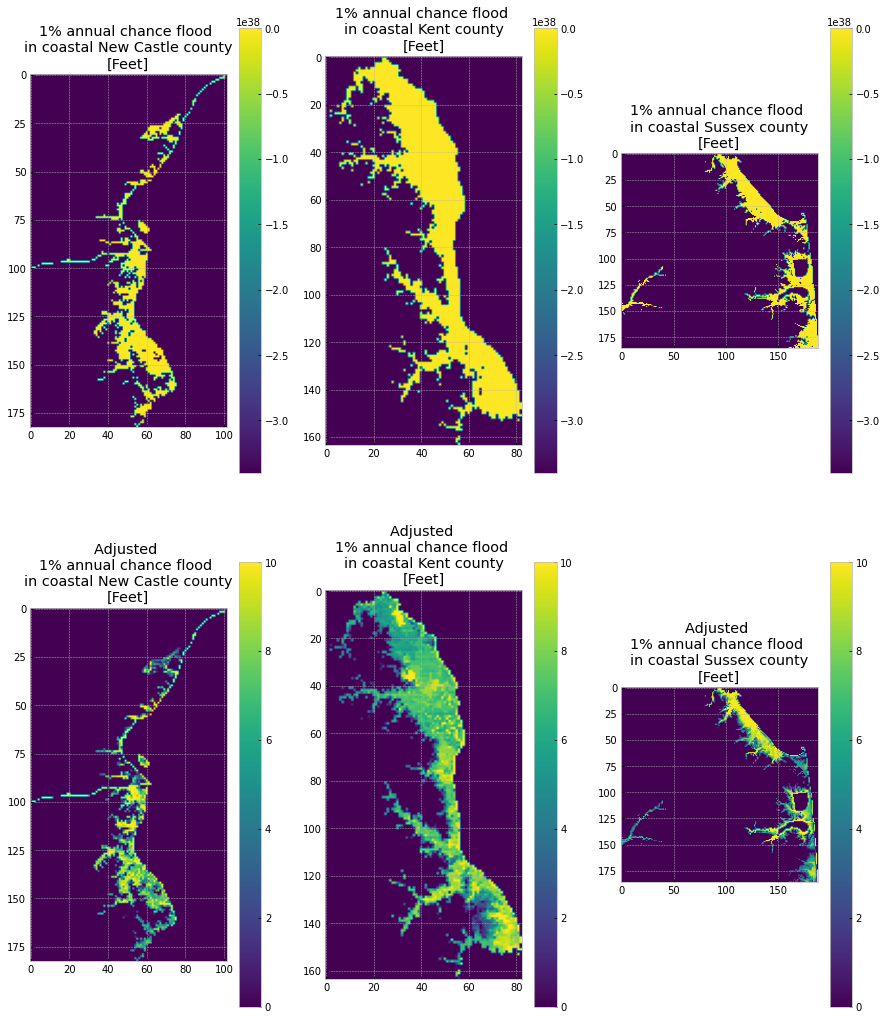

In [12]:
# -- plot raster 
fig_raster_ed, ax = plt.subplots(2, 3, figsize=[15, 18])
im0 = ax[0,0].imshow(dep_grid_3c)
im1 = ax[0,1].imshow(dep_grid_1c)
im2 = ax[0,2].imshow(dep_grid_5c)
im3 = ax[1,0].imshow(dep_grid_3c.clip(0,10))
im4 = ax[1,1].imshow(dep_grid_1c.clip(0,10))
im5 = ax[1,2].imshow(dep_grid_5c.clip(0,10))

ax[0,0].set_title("1% annual chance flood \nin coastal New Castle county\n[Feet]")
ax[0,1].set_title("1% annual chance flood \nin coastal Kent county\n[Feet]")
ax[0,2].set_title("1% annual chance flood \nin coastal Sussex county\n[Feet]")
ax[1,0].set_title("Adjusted \n1% annual chance flood \nin coastal New Castle county\n[Feet]")
ax[1,1].set_title("Adjusted \n1% annual chance flood \nin coastal Kent county\n[Feet]")
ax[1,2].set_title("Adjusted \n1% annual chance flood \nin coastal Sussex county\n[Feet]")

fig_raster_ed.colorbar(im0, ax=ax[0,0])
fig_raster_ed.colorbar(im1, ax=ax[0,1])
fig_raster_ed.colorbar(im2, ax=ax[0,2])
fig_raster_ed.colorbar(im3, ax=ax[1,0])
fig_raster_ed.colorbar(im4, ax=ax[1,1])
fig_raster_ed.colorbar(im5, ax=ax[1,2])

fig_raster_ed.savefig("/content/drive/My Drive/flooding/figure")

# Block Group shapefile

571


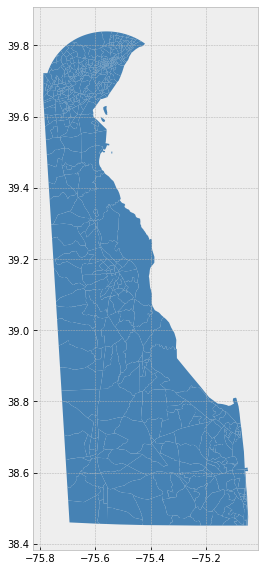

In [32]:
# -- load the census block group (2010)
cblkname = "/content/drive/My Drive/flooding/data/censusblock/Census_Block_Groups_2010/Census_Block_Groups_2010.shp"
decblkg_2010 = gp.read_file(cblkname)
#decblkg_2010.head()
print(len(decblkg_2010))
decblkg_2010.plot(color="steelblue")

# Socioeconomic status (SES) data processing

In [13]:
# -- lablel plot
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

#--Getting standardized values
def standardize(dataframe, original_column_name:str, intended_column_name:str):
  values = dataframe[original_column_name]
  values_mean = values.mean()
  values_stdev = values.std()
  standardized_values = []
  for i in values:
    standardized_values.append((i-values_mean)/values_stdev)
  dataframe[intended_column_name] = standardized_values

In [14]:
!pip install censusdata

     |████████████████████████████████| 23.2MB 1.5MB/s 
  Created wheel for censusdata: filename=CensusData-1.8-cp36-none-any.whl size=24706121 sha256=842c6c798d9491b832303a6b0603b09ed2cff27965bd686c7344eaa071a565db
  Stored in directory: /root/.cache/pip/wheels/76/04/a7/086077b0f4dee8f4c81dc16389b84a1add31d6626f3e0985fd
Successfully built censusdata


In [15]:
import censusdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Median household income

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B19049_001E  | B19049. Median Household Incom | !! Median household income in the past 12 months (in 201 | int  
B19049_002E  | B19049. Median Household Incom | !! Median household income in the past 12 months (in 201 | int  
B19049_003E  | B19049. Median Household Incom | !! Median household income in the past 12 months (in 201 | int  
B19049_004E  | B19049. Median Household Incom | !! Median household income in the past 12 months (in 201 | int  
B19049_005E  | B19049. Median Household Incom | !! Median household income in the past 12 months (in 201 | int  
-------------------------------------------------------------------------------------------------------------------
             mincome    mincome_st
count     574.000000  5.740000e+02
mean    63400.759582

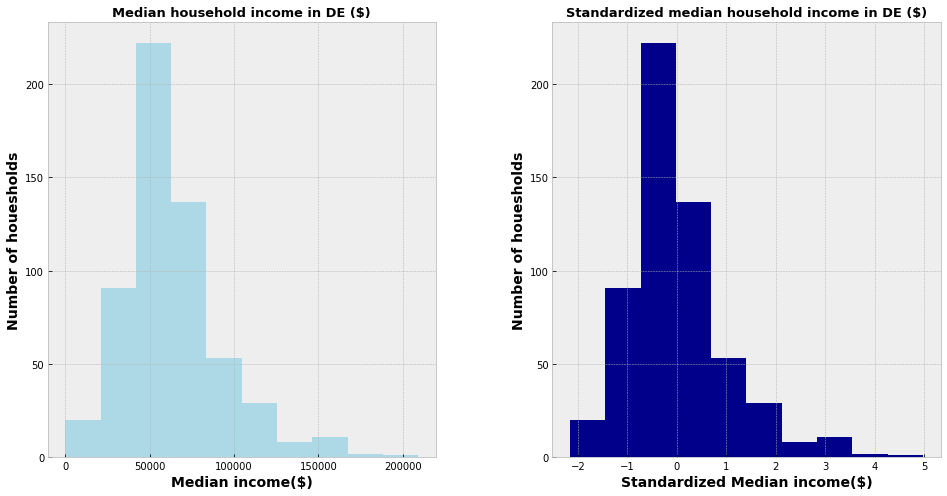

In [16]:
# -- Median household income by census block group

censusdata.censustable('acs5', 2014, 'B19049')
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B19049'))
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
income_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '001'), ('block group', '*')]), ["B19049_001E"])
de_income_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B19049_001E"]) for i in ["003", "001", "005"]])
de_income_cblkg['mincome'] = de_income_cblkg["B19049_001E"].clip(0,1e9).dropna() 

#--Getting standardized values
standardize(de_income_cblkg, "mincome", "mincome_st")
de_income_cblkg = de_income_cblkg[["mincome", "mincome_st"]]
#--data description
print(de_income_cblkg.describe())
#--histogram
#de_income_cblkg.clip(0, 1e9).hist(["mincome"], bins=30)
fig_income, ax=plt.subplots(nrows=1, ncols=2, figsize=[16, 8])
plot0 = ax[0]
plot1 = ax[1]

de_income_cblkg.hist("mincome", color="lightblue", ax=plot0)
label_plot(plot0,"Median household income in DE ($)", "Median income($)", "Number of houesholds",axis_size=14, title_size=13)

de_income_cblkg.hist("mincome_st", color="darkblue", ax=plot1)
label_plot(plot1, "Standardized median household income in DE ($)", "Standardized Median income($)", "Number of houesholds",  axis_size=14, title_size=13)

fig_income.show()

## Race 

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B02001_001E  | B02001.  Race                  | Total:                                                   | int  
B02001_002E  | B02001.  Race                  | White alone                                              | int  
B02001_003E  | B02001.  Race                  | Black or African American alone                          | int  
B02001_004E  | B02001.  Race                  | American Indian and Alaska Native alone                  | int  
B02001_005E  | B02001.  Race                  | Asian alone                                              | int  
B02001_006E  | B02001.  Race                  | Native Hawaiian and Other Pacific Islander alone         | int  
B02001_007E  | B02001.  Race                  | Some other race alone                        

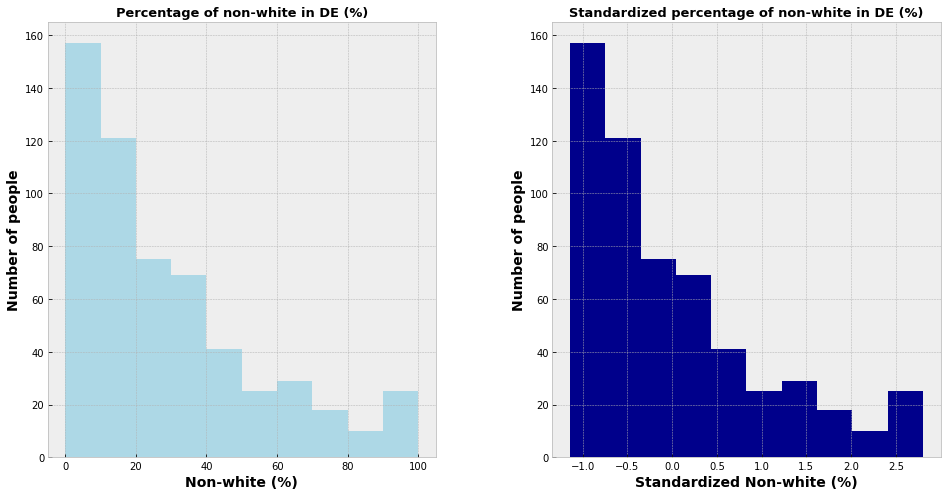

In [17]:
# -- Racial factors (White alone / Total) by census block group
censusdata.censustable('acs5', 2014, 'B02001')
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B02001'))
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
race_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '001'), ('block group', '*')]), ["B02001_001E", "B02001_002E"])
de_race_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B02001_001E", "B02001_002E"]) for i in ["003", "001", "005"]])
de_race_cblkg['per_white'] = de_race_cblkg["B02001_002E"] / de_race_cblkg["B02001_001E"] * 100
de_race_cblkg['per_nonwhite'] = (de_race_cblkg["B02001_001E"] - de_race_cblkg["B02001_002E"])/de_race_cblkg["B02001_001E"] *100
de_race_cblkg = de_race_cblkg[['per_white', 'per_nonwhite']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(de_race_cblkg, "per_nonwhite", "per_nonwhite_st")
de_race_cblkg = de_race_cblkg[["per_nonwhite", "per_nonwhite_st"]]
#--data description
print(de_race_cblkg.describe())
#--histogram
#de_race_cblkg.clip(0, 1e9).hist(["per_nonwhite_st"], bins=30)
fig_race, ax=plt.subplots(nrows=1, ncols=2, figsize=[16, 8])
plot0 = ax[0]
plot1 = ax[1]

de_race_cblkg.hist("per_nonwhite", color="lightblue", ax=plot0)
label_plot(plot0,"Percentage of non-white in DE (%)", "Non-white (%)", "Number of people",axis_size=14, title_size=13)

de_race_cblkg.hist("per_nonwhite_st", color="darkblue", ax=plot1)
label_plot(plot1, "Standardized percentage of non-white in DE (%)", "Standardized Non-white (%)", "Number of people",  axis_size=14, title_size=13)

fig_race.show()

## Poverty 

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B17010_001E  | B17010.  Poverty Status of Fam | Total:                                                   | int  
B17010_002E  | B17010.  Poverty Status of Fam | Income in the past 12 months below poverty level:        | int  
B17010_003E  | B17010.  Poverty Status of Fam | !! Income in the past 12 months below poverty level: Mar | int  
B17010_004E  | B17010.  Poverty Status of Fam | !! !! Income in the past 12 months below poverty level:  | int  
B17010_005E  | B17010.  Poverty Status of Fam | !! !! !! Income in the past 12 months below poverty leve | int  
B17010_006E  | B17010.  Poverty Status of Fam | !! !! !! Income in the past 12 months below poverty leve | int  
B17010_007E  | B17010.  Poverty Status of Fam | !! !! !! Income in the past 12 months below p

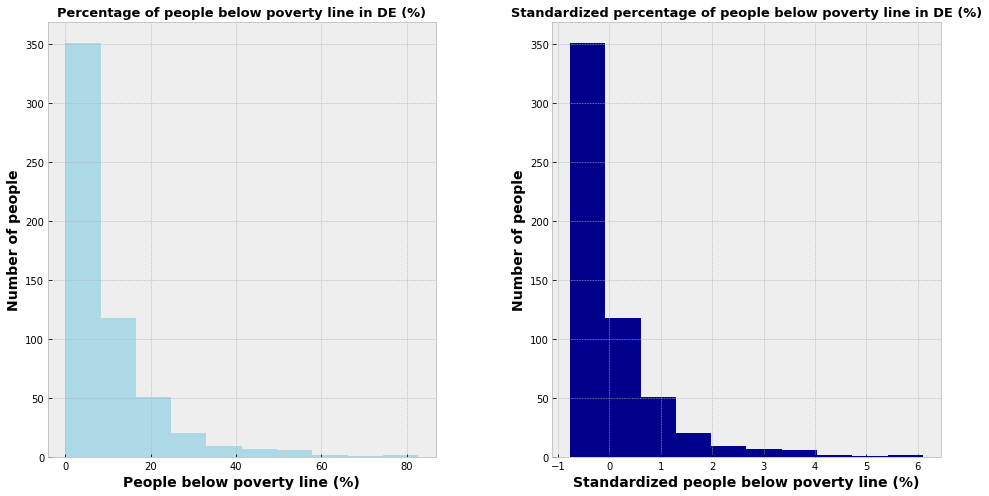

In [18]:
# Poverty rate by census block group
censusdata.censustable('acs5', 2014, 'B17010')
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B17010'))
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
poverty_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '001'), ('block group', '*')]), ["B17010_001E", "B17010_002E"])
de_poverty_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B17010_001E", "B17010_002E"]) for i in ["003", "001", "005"]])
de_poverty_cblkg['per_below_povlev'] = de_poverty_cblkg["B17010_002E"] / de_poverty_cblkg["B17010_001E"] * 100
de_poverty_cblkg = de_poverty_cblkg[['per_below_povlev']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(de_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
de_poverty_cblkg = de_poverty_cblkg[["per_below_povlev", "per_below_povlev_st"]]
#--data description
print(de_poverty_cblkg.describe())
#--histogram
#de_poverty_cblkg.clip(0, 1e9).hist(['per_below_povlev_st'], bins=30)
fig_poverty, ax=plt.subplots(nrows=1, ncols=2, figsize=[16, 8])
plot0 = ax[0]
plot1 = ax[1]

de_poverty_cblkg.hist("per_below_povlev", color="lightblue", ax=plot0)
label_plot(plot0,"Percentage of people below poverty line in DE (%)", "People below poverty line (%)", "Number of people",axis_size=14, title_size=13)

de_poverty_cblkg.hist("per_below_povlev_st", color="darkblue", ax=plot1)
label_plot(plot1, "Standardized percentage of people below poverty line in DE (%)", "Standardized people below poverty line (%)", "Number of people",  axis_size=14, title_size=13)

fig_poverty.show()

## Set GEOID & Merge dataframe

In [19]:
# -- data processing 
# Block Group 1, Census Tract 130, New Castle County, Delaware: Summary level: 150, state:10> county:003> tract:013000> block group:1

# -- initialize GEOID container
geoids = []

# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in de_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])

# -- set GEOID column in income DataFrame
de_income_cblkg["cblockgid"] = geoids

In [20]:
# -- Race Data 

# -- initialize GEOID container
geoids = []

# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in de_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])

# -- set GEOID column in income DataFrame
de_race_cblkg["cblockgid"] = geoids

In [21]:
# -- Poverty Data 

# -- initialize GEOID container
geoids = []

# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in de_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])

# -- set GEOID column in income DataFrame
de_poverty_cblkg["cblockgid"] = geoids

In [22]:
# Merging with census tract geodataframe
race_income_poverty = de_income_cblkg.merge(de_race_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(de_poverty_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid")
demo = race_income_poverty
demo = demo[["cblockgid", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]]
demo.head()

,cblockgid,mincome,mincome_st,per_nonwhite,per_nonwhite_st,per_below_povlev,per_below_povlev_st
0,100030130001,55769,-0.260459,9.702970,-0.758276,0.000000,-0.766925
1,100030130002,49327,-0.480314,4.767184,-0.952852,5.339806,-0.323319
2,100030131001,75313,0.406545,9.282700,-0.774844,16.923077,0.638963
3,100030131002,61000,-0.081934,9.943182,-0.748807,4.145078,-0.422572
4,100030131003,59853,-0.121079,1.121795,-1.096559,0.000000,-0.766925


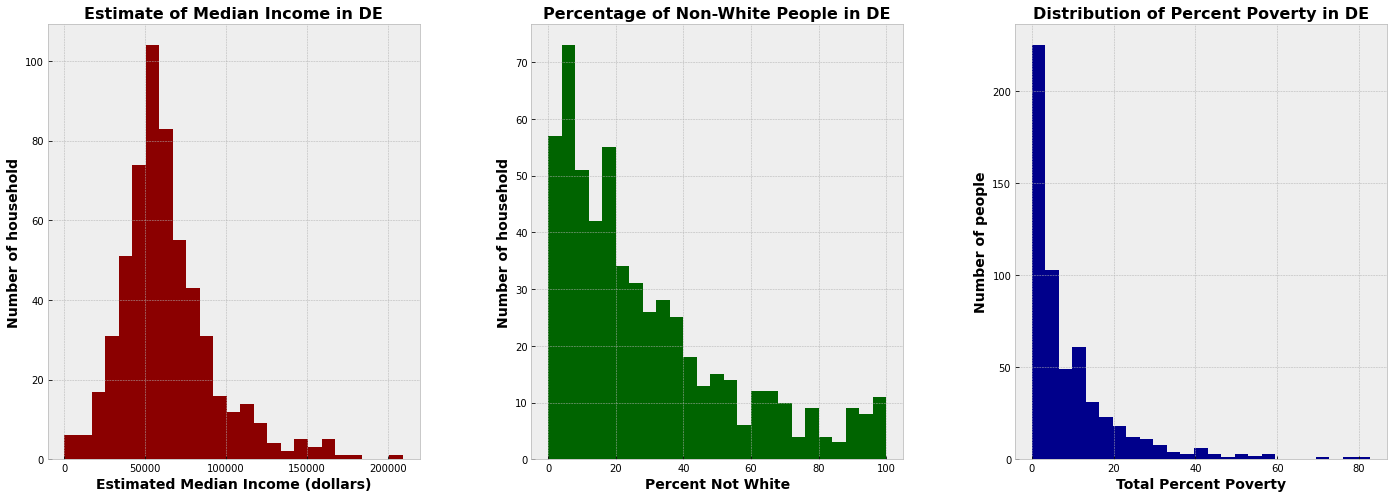

In [23]:
fig_demo, ax=plt.subplots(nrows=1, ncols=3, figsize=[24, 8])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

demo.hist('mincome', ax=plot0, bins=25, color="darkred")
label_plot(plot0, "Estimate of Median Income in DE", "Estimated Median Income (dollars)", "Number of household", axis_size=14, title_size=16)
demo.hist('per_nonwhite', ax=plot1, bins=25, color="darkgreen")
label_plot(plot1, "Percentage of Non-White People in DE", "Percent Not White", "Number of household", title_size=16, axis_size=14)
demo.hist("per_below_povlev", ax=plot2, bins=25, color="darkblue")
label_plot(plot2, "Distribution of Percent Poverty in DE", "Total Percent Poverty", "Number of people", title_size=16, axis_size=14)
fig_demo.show()

# Geocoding: Raster data to Census block group shapefile, Shapefile to SES data


## Merge raster data

In [24]:
# -- create a DataFrame of the depth grid
df_dgrid_1c = pd.DataFrame(columns=["lat", "lon", "dep"])
df_dgrid_3c = pd.DataFrame(columns=["lat", "lon", "dep"])
df_dgrid_5c = pd.DataFrame(columns=["lat", "lon", "dep"])

In [25]:
# -- renaming for ease of use...
dep_grid_1c = arr1C_Cst_Dpth01pct
dep_grid_3c = arr3C_Cst_Dpth01pct
dep_grid_5c = arr5C_Cst_Dpth01pct

In [26]:
# -- assign column values
df_dgrid_1c["lat"] = lat_grid_1c.flatten()
df_dgrid_1c["lon"] = lon_grid_1c.flatten()
df_dgrid_1c["dep"] = dep_grid_1c.flatten()

df_dgrid_3c["lat"] = lat_grid_3c.flatten()
df_dgrid_3c["lon"] = lon_grid_3c.flatten()
df_dgrid_3c["dep"] = dep_grid_3c.flatten()

df_dgrid_5c["lat"] = lat_grid_5c.flatten()
df_dgrid_5c["lon"] = lon_grid_5c.flatten()
df_dgrid_5c["dep"] = dep_grid_5c.flatten()

In [27]:
def make_point(x):
  return Point(x["lon"], x["lat"])
  make_point(df_dgrid.iloc[0])

In [28]:
# -- make points
df_dgrid_1c["geometry"] = df_dgrid_1c.apply(make_point, axis=1)
df_dgrid_3c["geometry"] = df_dgrid_3c.apply(make_point, axis=1)
df_dgrid_5c["geometry"] = df_dgrid_5c.apply(make_point, axis=1)

In [29]:
# -- merge dataframe by column names
df_dgrid = pd.concat([df_dgrid_1c, df_dgrid_3c, df_dgrid_5c])
df_dgrid

,lat,lon,dep,geometry
0,39.367209,-75.600060,-3.402823e+38,POINT (-75.60006 39.367209)
1,39.367209,-75.596558,-3.402823e+38,POINT (-75.59655757831325 39.367209)
2,39.367209,-75.593055,-3.402823e+38,POINT (-75.59305515662651 39.367209)
3,39.367209,-75.589553,-3.402823e+38,POINT (-75.58955273493976 39.367209)
4,39.367209,-75.586050,-3.402823e+38,POINT (-75.58605031325301 39.367209)
...,...,...,...,...
34963,38.453633,-75.061792,6.000000e+00,POINT (-75.06179159574469 38.45363253225806)
34964,38.453633,-75.058284,6.000000e+00,POINT (-75.05828427659576 38.45363253225806)
34965,38.453633,-75.054777,2.600000e+00,POINT (-75.05477695744682 38.45363253225806)
34966,38.453633,-75.051270,1.700000e+00,POINT (-75.05126963829788 38.45363253225806)


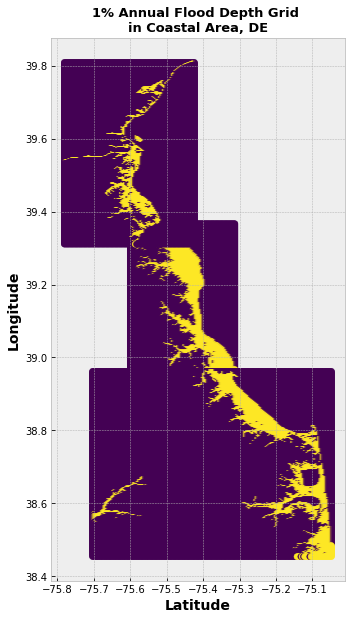

In [30]:
# -- convert to geodataframe
df_dgrid_1c = gp.GeoDataFrame(df_dgrid_1c)
df_dgrid_3c = gp.GeoDataFrame(df_dgrid_3c)
df_dgrid_5c = gp.GeoDataFrame(df_dgrid_5c)
# -- merge geodataframe
df_dgrid = gp.GeoDataFrame(df_dgrid)
#--plot
ax = df_dgrid.plot("dep")
label_plot(ax, "1% Annual Flood Depth Grid \nin Coastal Area, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

## Geospatial join raster data to census tract shapefile

In [33]:
# -- Perform a spatial join between the Raster data and Census block shape file
df_dgrid_1c_decblkg_2010 = gp.sjoin(df_dgrid_1c, decblkg_2010)
df_dgrid_3c_decblkg_2010 = gp.sjoin(df_dgrid_3c, decblkg_2010)
df_dgrid_5c_decblkg_2010 = gp.sjoin(df_dgrid_5c, decblkg_2010)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  after removing the cwd from sys.path.


In [34]:
# -- Merge county level data to make state level data 
df_dgrid_cblkg = pd.concat([df_dgrid_1c_decblkg_2010, df_dgrid_3c_decblkg_2010,df_dgrid_5c_decblkg_2010])
df_dgrid_cblkg["dep_cl"] = df_dgrid_cblkg["dep"].clip(0, 1e6)
df_dgrid_cblkg.head()

,lat,lon,dep,geometry,index_right,OBJECTID,COUNTYFP10,BLKGRPCE10,GEOID10,NAMELSAD10,POPULATION,HOUSING_UN,NAME10,dep_cl
0,39.367209,-75.600060,-3.402823e+38,POINT (-75.60006 39.36721),149,172,003,2,100030169042,Block Group 2,1521,599,169.04,0.0
1,39.367209,-75.596558,-3.402823e+38,POINT (-75.59656 39.36721),149,172,003,2,100030169042,Block Group 2,1521,599,169.04,0.0
2,39.367209,-75.593055,-3.402823e+38,POINT (-75.59306 39.36721),149,172,003,2,100030169042,Block Group 2,1521,599,169.04,0.0
3,39.367209,-75.589553,-3.402823e+38,POINT (-75.58955 39.36721),149,172,003,2,100030169042,Block Group 2,1521,599,169.04,0.0
4,39.367209,-75.586050,-3.402823e+38,POINT (-75.58605 39.36721),149,172,003,2,100030169042,Block Group 2,1521,599,169.04,0.0


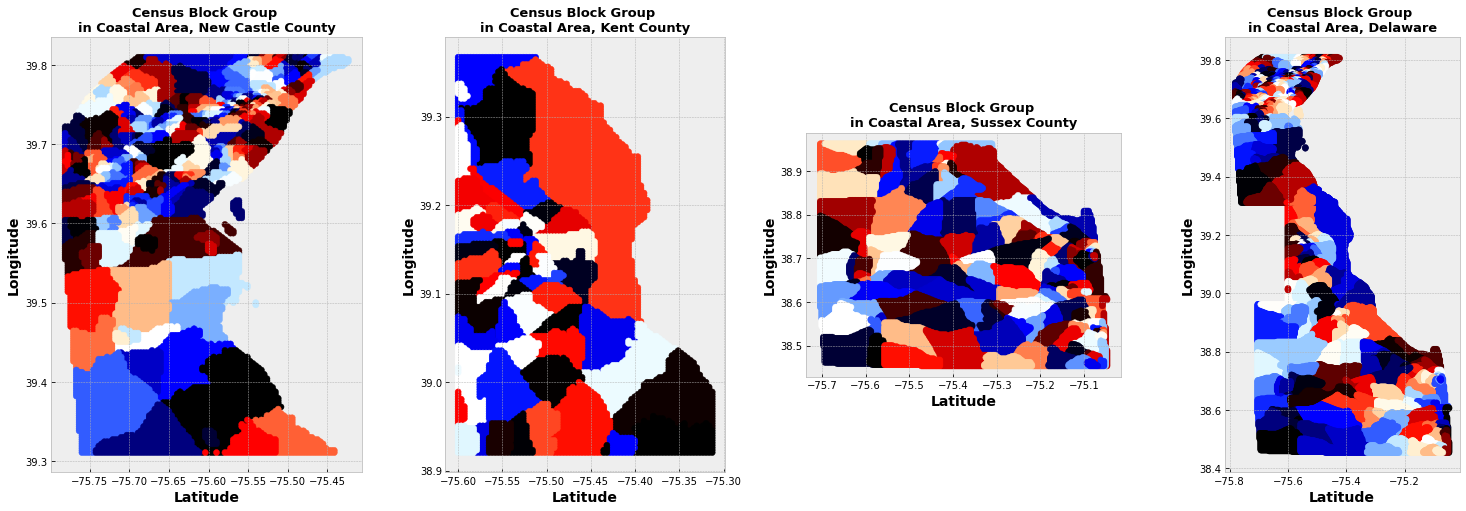

In [35]:
# -- Plot 
fig_df_dgrid_cblkg, ax=plt.subplots(nrows=1, ncols=4, figsize=[26, 8])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]
plot3 = ax[3]

df_dgrid_3c_decblkg_2010.plot("GEOID10", cmap="flag", ax=plot0)
label_plot(plot0, "Census Block Group \nin Coastal Area, New Castle County", "Latitude", "Longitude", axis_size=14, title_size=13)

df_dgrid_1c_decblkg_2010.plot("GEOID10", cmap="flag", ax=plot1)
label_plot(plot1, "Census Block Group \nin Coastal Area, Kent County", "Latitude", "Longitude", axis_size=14, title_size=13)

df_dgrid_5c_decblkg_2010.plot("GEOID10", cmap="flag", ax=plot2)
label_plot(plot2, "Census Block Group \nin Coastal Area, Sussex County", "Latitude", "Longitude", axis_size=14, title_size=13)

df_dgrid_cblkg.plot("GEOID10", cmap="flag", ax=plot3)
label_plot(plot3, "Census Block Group \nin Coastal Area, Delaware", "Latitude", "Longitude", axis_size=14, title_size=13)

fig_df_dgrid_cblkg.show()

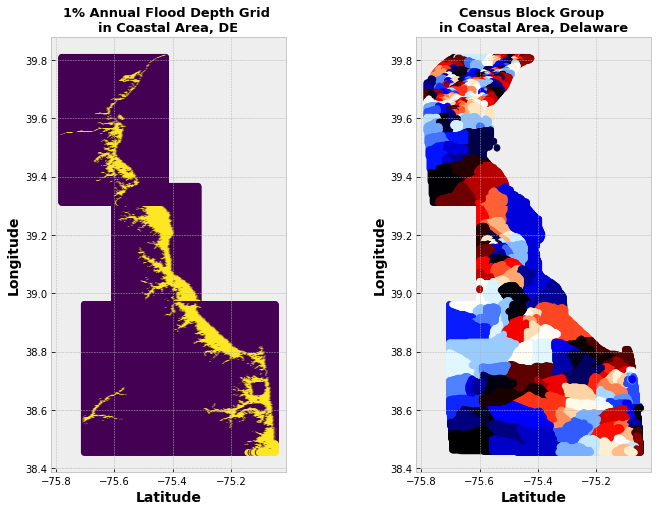

In [36]:
# -- Plot 
fig_dgrid_cblkg, ax=plt.subplots(nrows=1, ncols=2, figsize=[12, 8])
plot0 = ax[0]
plot1 = ax[1]

df_dgrid.plot("dep", ax=plot0)
label_plot(plot0, "1% Annual Flood Depth Grid \nin Coastal Area, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

df_dgrid_cblkg.plot("GEOID10", cmap="flag", ax=plot1)
label_plot(plot1, "Census Block Group \nin Coastal Area, Delaware", "Latitude", "Longitude", axis_size=14, title_size=13)

fig_dgrid_cblkg.show()

In [37]:
# -- Using "groupby" GEOID to get the average number of depth (1% annual chance flood)
df_dgrid_g = df_dgrid_cblkg.groupby("GEOID10").mean().reset_index()
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl"]
df_dgrid_sub = df_dgrid_g[cols]
df_dgrid_sub

,GEOID10,lat,lon,dep,dep_cl
0,100010402021,39.293188,-75.600060,-3.402823e+38,0.000000
1,100010402022,39.256092,-75.594958,-3.402823e+38,0.000000
2,100010402031,39.272196,-75.588177,-3.402823e+38,0.000000
3,100010402032,39.298997,-75.549335,-2.869642e+38,0.712484
4,100010405011,39.207091,-75.553653,-3.402823e+38,0.000000
...,...,...,...,...,...
545,100050518012,38.581556,-75.603212,-3.301892e+38,0.168220
546,100050518021,38.539984,-75.577980,-3.348810e+38,0.050794
547,100050518022,38.541511,-75.563716,-3.350472e+38,0.112308
548,100050519001,38.492057,-75.639175,-3.402823e+38,0.000000


In [38]:
# -- Merge back with the original GEOID10
decblkg_2010_df_dgrid_sub = decblkg_2010.merge(df_dgrid_sub, on="GEOID10")
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl", "geometry"]
decblkg_2010_df_dgrid_sub_cols = decblkg_2010_df_dgrid_sub[cols]
decblkg_2010_df_dgrid_sub_cols 

,GEOID10,lat,lon,dep,dep_cl,geometry
0,100010432023,39.046939,-75.433918,-1.426679e+38,3.952975,"POLYGON ((-75.39664 39.05831, -75.39736 39.058..."
1,100010432022,39.010953,-75.405610,-1.756742e+38,3.331098,"POLYGON ((-75.39664 39.05831, -75.39563 39.058..."
2,100010432024,38.974912,-75.363448,-1.484165e+38,4.004172,"POLYGON ((-75.35792 39.03170, -75.35241 39.036..."
3,100010405021,39.223601,-75.538166,-2.903567e+38,0.640154,"POLYGON ((-75.52454 39.22149, -75.52682 39.219..."
4,100010405022,39.190950,-75.501076,-3.402823e+38,0.000000,"POLYGON ((-75.52036 39.18897, -75.52192 39.190..."
...,...,...,...,...,...,...
545,100030135014,39.785419,-75.659024,-3.402823e+38,0.000000,"POLYGON ((-75.64042 39.77548, -75.64046 39.775..."
546,100030135011,39.801708,-75.689280,-3.402823e+38,0.000000,"POLYGON ((-75.69650 39.80558, -75.69638 39.805..."
547,100030135013,39.759461,-75.654072,-3.402823e+38,0.000000,"POLYGON ((-75.63990 39.76219, -75.64013 39.761..."
548,100030135012,39.751089,-75.640312,-3.402823e+38,0.000000,"POLYGON ((-75.64041 39.76148, -75.64023 39.761..."


In [39]:
print(decblkg_2010_df_dgrid_sub_cols["dep_cl"].min())
print(decblkg_2010_df_dgrid_sub_cols["dep_cl"].max())

0.0
9.613333702087402


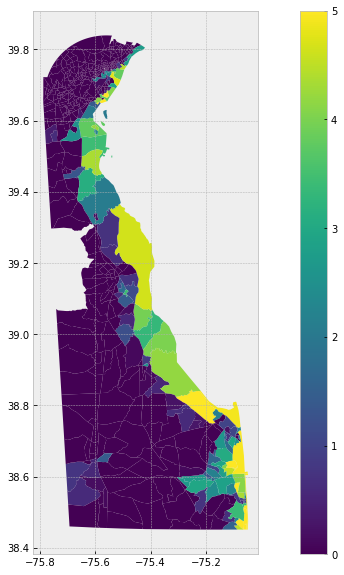

In [40]:
decblkg_2010_df_dgrid_sub_cols.plot("dep_cl", legend=True, vmax=5)

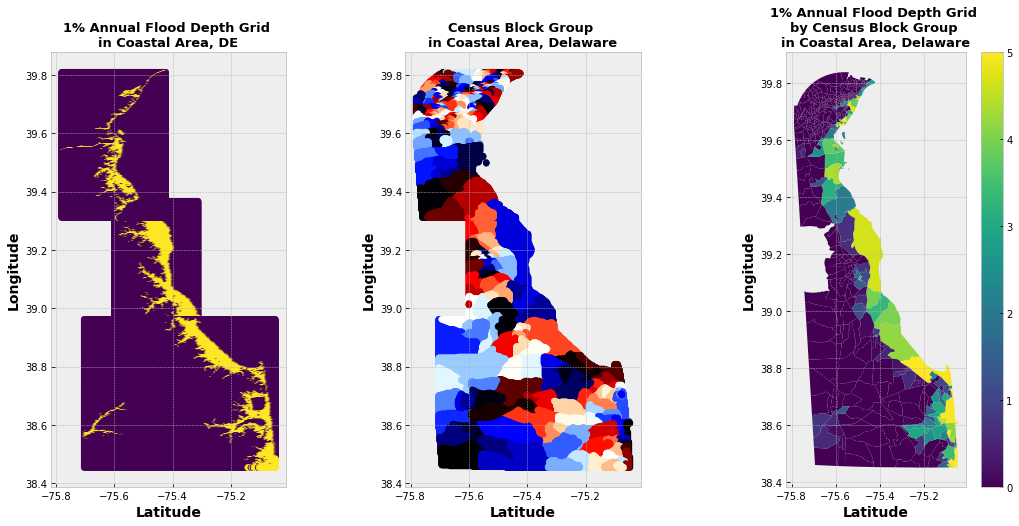

In [41]:
# -- Plot 
fig_dgrid_cblkg_merge, ax=plt.subplots(nrows=1, ncols=3, figsize=[18, 8])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

df_dgrid.plot("dep", ax=plot0)
label_plot(plot0, "1% Annual Flood Depth Grid \nin Coastal Area, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

df_dgrid_cblkg.plot("GEOID10", cmap="flag", ax=plot1)
label_plot(plot1, "Census Block Group \nin Coastal Area, Delaware", "Latitude", "Longitude", axis_size=14, title_size=13)

decblkg_2010_df_dgrid_sub_cols.plot("dep_cl", legend=True, vmax=5, ax=plot2)
label_plot(plot2, "1% Annual Flood Depth Grid \nby Census Block Group \nin Coastal Area, Delaware", "Latitude", "Longitude", axis_size=14, title_size=13)

fig_dgrid_cblkg_merge.show()

## Merge geodata to social factors data 

In [42]:
# -- Merge geodata to demographic factors data
decblkg_2010_df_dgrid_sub_cols_demo = decblkg_2010_df_dgrid_sub_cols.merge(demo, left_on="GEOID10", right_on="cblockgid",how="left")

# -- Rename dataset
data = decblkg_2010_df_dgrid_sub_cols_demo

# -- Reframe dataset
cols = ["cblockgid", "geometry", "lat", "lon", 
        "dep", "dep_cl",
        "mincome", "mincome_st", 
        "per_nonwhite", "per_nonwhite_st",  
        "per_below_povlev", "per_below_povlev_st"]
data_sub = data[cols]
data_sub.columns = ["cblockgid", "geometry", "lat", "lon", 
                    "dep", "dep_cl", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]
data_sub = data_sub.fillna(0)
data_sub

,cblockgid,geometry,lat,lon,dep,dep_cl,mincome,mincome_st,per_nonwhite,per_nonwhite_st,per_below_povlev,per_below_povlev_st
0,100010432023,"POLYGON ((-75.39664 39.05831, -75.39736 39.058...",39.046939,-75.433918,-1.426679e+38,3.952975,40357,-0.786445,7.963446,-0.826851,11.398964,0.180046
1,100010432022,"POLYGON ((-75.39664 39.05831, -75.39563 39.058...",39.010953,-75.405610,-1.756742e+38,3.331098,57083,-0.215615,18.039216,-0.429649,5.555556,-0.305396
2,100010432024,"POLYGON ((-75.35792 39.03170, -75.35241 39.036...",38.974912,-75.363448,-1.484165e+38,4.004172,54102,-0.317351,13.801079,-0.596722,14.243323,0.416342
3,100010405021,"POLYGON ((-75.52454 39.22149, -75.52682 39.219...",39.223601,-75.538166,-2.903567e+38,0.640154,84167,0.708717,36.639118,0.303588,0.000000,-0.766925
4,100010405022,"POLYGON ((-75.52036 39.18897, -75.52192 39.190...",39.190950,-75.501076,-3.402823e+38,0.000000,40175,-0.792656,53.834808,0.981468,3.473945,-0.478326
...,...,...,...,...,...,...,...,...,...,...,...,...
545,100030135014,"POLYGON ((-75.64042 39.77548, -75.64046 39.775...",39.785419,-75.659024,-3.402823e+38,0.000000,101944,1.315416,10.293526,-0.734995,0.000000,-0.766925
546,100030135011,"POLYGON ((-75.69650 39.80558, -75.69638 39.805...",39.801708,-75.689280,-3.402823e+38,0.000000,143558,2.735632,8.138447,-0.819952,5.167173,-0.337661
547,100030135013,"POLYGON ((-75.63990 39.76219, -75.64013 39.761...",39.759461,-75.654072,-3.402823e+38,0.000000,111971,1.657621,11.242300,-0.697593,0.000000,-0.766925
548,100030135012,"POLYGON ((-75.64041 39.76148, -75.64023 39.761...",39.751089,-75.640312,-3.402823e+38,0.000000,74732,0.386716,6.837607,-0.871233,0.000000,-0.766925


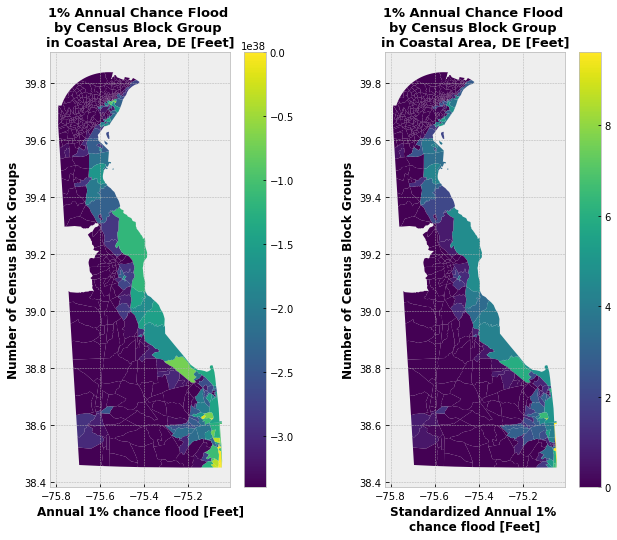

In [43]:
# -- Plot
fig_data_sub, ax=plt.subplots(nrows=1, ncols=2, figsize=[11, 8])
plot0 = ax[0]
plot1 = ax[1]

data_sub.plot("dep", ax=plot0, legend=True)
label_plot(plot0, "1% Annual Chance Flood \nby Census Block Group \nin Coastal Area, DE [Feet]", "Annual 1% chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

data_sub.plot("dep_cl", ax=plot1, legend=True)
label_plot(plot1, "1% Annual Chance Flood \nby Census Block Group \nin Coastal Area, DE [Feet]", "Standardized Annual 1% \nchance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

fig_data_sub.show()

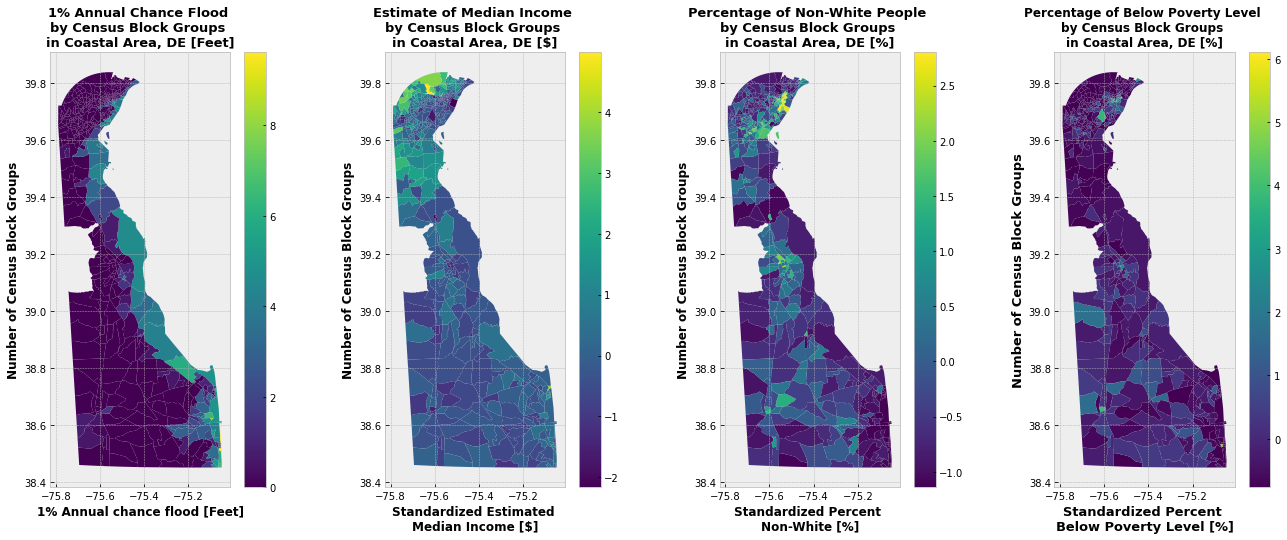

In [44]:
# -- Plot
fig_data_sub, ax=plt.subplots(nrows=1, ncols=4, figsize=[23, 8])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]
plot3 = ax[3]

data_sub.plot("dep_cl", ax=plot0, legend=True)
label_plot(plot0, "1% Annual Chance Flood \nby Census Block Groups \nin Coastal Area, DE [Feet]", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

data_sub.plot("mincome_st", ax=plot1, legend=True)
label_plot(plot1, "Estimate of Median Income \nby Census Block Groups \nin Coastal Area, DE [$]", "Standardized Estimated \nMedian Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

data_sub.plot("per_nonwhite_st", ax=plot2, legend=True)
label_plot(plot2, "Percentage of Non-White People \nby Census Block Groups \nin Coastal Area, DE [%]", "Standardized Percent \nNon-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

data_sub.plot("per_below_povlev_st", ax=plot3, legend=True)
label_plot(plot3, "Percentage of Below Poverty Level \nby Census Block Groups \nin Coastal Area, DE [%]", "Standardized Percent \nBelow Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

fig_data_sub.show()

# Correlation

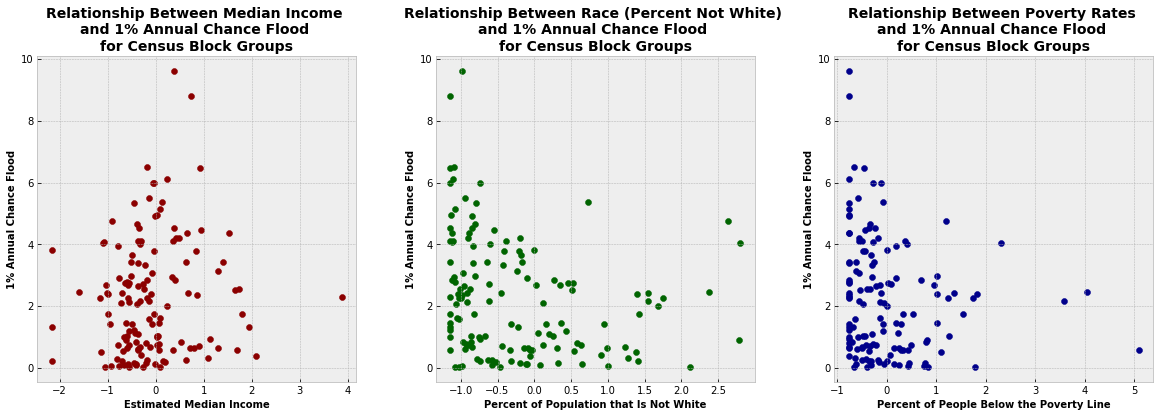

In [46]:
# correlation 

fig_data_sub_cor_st, ax = plt.subplots(nrows=1, ncols=3, figsize=[20, 6])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

# -- GGD: let's concentrate only on place where there will be flood
data_sub_fl = data_sub[data_sub["dep_cl"] > 0]

#plot 0
plot0.scatter(data_sub_fl["mincome_st"], data_sub_fl["dep_cl"], color="darkred")
label_plot(plot0, "Relationship Between Median Income \nand 1% Annual Chance Flood \nfor Census Block Groups", "Estimated Median Income", "1% Annual Chance Flood", title_size=14, axis_size=10)
#plot 1
plot1.scatter(data_sub_fl["per_nonwhite_st"], data_sub_fl["dep_cl"], color="darkgreen")
label_plot(plot1, "Relationship Between Race (Percent Not White) \nand 1% Annual Chance Flood \nfor Census Block Groups", "Percent of Population that Is Not White", "1% Annual Chance Flood", title_size=14, axis_size=10)
#plot 2
plot2.scatter(data_sub_fl["per_below_povlev_st"], data_sub_fl["dep_cl"], color="darkblue")
label_plot(plot2, "Relationship Between Poverty Rates \nand 1% Annual Chance Flood \nfor Census Block Groups", "Percent of People Below the Poverty Line", "1% Annual Chance Flood", title_size=14, axis_size=10)

fig_data_sub_cor_st.subplots_adjust(wspace=.25, hspace=.4)
fig_data_sub_cor_st.show()

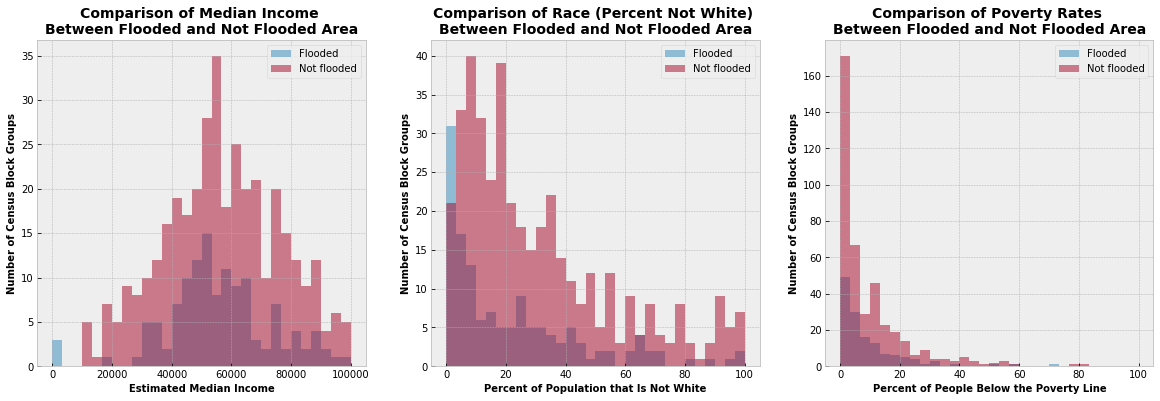

In [47]:
# -- set a threshold for "flooded"
thr = 0.01

# -- flooded census block groups
data_sub_fl = data_sub[data_sub["dep_cl"] >= thr]

# -- not-flooded census block groups
data_sub_nf = data_sub[data_sub["dep_cl"] < thr]

# -- make histograms
fig_ses_compare, ax = plt.subplots(1, 3, figsize=[20, 6])
ax[0].hist(data_sub_fl["mincome"], range=[0, 100000], bins=30, alpha=0.5, label="Flooded")
ax[0].hist(data_sub_nf["mincome"], range=[0, 100000], bins=30, alpha=0.5, label="Not flooded")
ax[0].legend()
label_plot(ax[0], "Comparison of Median Income \nBetween Flooded and Not Flooded Area", "Estimated Median Income", "Number of Census Block Groups", title_size=14, axis_size=10)

ax[1].hist(data_sub_fl["per_nonwhite"], range=[0, 100], bins=30, alpha=0.5, label="Flooded")
ax[1].hist(data_sub_nf["per_nonwhite"], range=[0, 100], bins=30, alpha=0.5, label="Not flooded")
ax[1].legend()
label_plot(ax[1], "Comparison of Race (Percent Not White) \nBetween Flooded and Not Flooded Area", "Percent of Population that Is Not White", "Number of Census Block Groups", title_size=14, axis_size=10)

ax[2].hist(data_sub_fl["per_below_povlev"], range=[0, 100], bins=30, alpha=0.5, label="Flooded")
ax[2].hist(data_sub_nf["per_below_povlev"], range=[0, 100], bins=30, alpha=0.5, label="Not flooded")
ax[2].legend()
label_plot(ax[2], "Comparison of Poverty Rates \nBetween Flooded and Not Flooded Area", "Percent of People Below the Poverty Line", "Number of Census Block Groups", title_size=14, axis_size=10)

fig_ses_compare.show()

In [48]:
from scipy import stats
from scipy.stats import ks_2samp
print("")
x1 = data_sub_fl["mincome"]
y1 = data_sub_nf["mincome"]
print(ks_2samp(x1, y1))
print("")
x2 = data_sub_fl["per_nonwhite"]
y2 = data_sub_nf["per_nonwhite"]
print(ks_2samp(x2, y2))
print("")
x3 = data_sub_fl["per_below_povlev"]
y3 = data_sub_nf["per_below_povlev"]
print(ks_2samp(x3, y3))
print("")


Ks_2sampResult(statistic=0.11059518784297172, pvalue=0.14525128998774228)

Ks_2sampResult(statistic=0.23575348248205993, pvalue=1.5020094614626167e-05)

Ks_2sampResult(statistic=0.081680033769523, pvalue=0.46350631553751986)



---

**GGD: streamline...**

reading Tiffs...
extracting to array...
  arrays extracted in 8.255001783370972s
loading census block group shapes...
  loaded in 0.09781551361083984s
generating depth DataFrame...
  extracting metadata for Kent
  extracting metadata for New Castle
  extracting metadata for Sussex
  assigning column values...
generating GeoDataFrame...
  creating geometry...
  geometry created in 9.197137832641602s
merging and converting to GeoDataFrame...
Spatial join on raster and Census blocks...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:221: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:223: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



  finished in 38.28258919715881s
merging with Census Block GeoDataFrame
Process completed in 56.2698712348938s
plotting result...


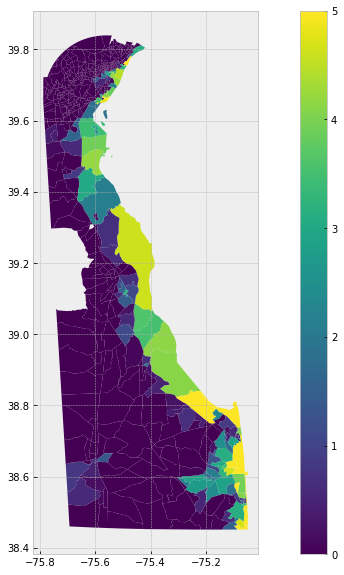

In [ ]:
# -- initialize timer
t00 = time.time()

# -- set filename : 1% depth / DE / coastal area 

print("reading Tiffs...")

# -- Kent (10001C)
fname1C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Kent/FRD_10001C_Coastal_GeoTIFFS_20140502/10001C_Coastal_CstDpth01pct.tif"

# -- New Castle (10003C)
fname3C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif"

# -- Sussex (1005C)
fname5C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Sussex/FRD_10005C_Coastal_GeoTIFFS_20140509/10005C_Coastal_CstDpth01pct.tif"

# -- create and read in a raster : 1% depth / DE / coastal area  
rast1C_Cst_Dpth01pct = gdal.Open(fname1C_Cst_Dpth01pct, GA_ReadOnly)
rast3C_Cst_Dpth01pct = gdal.Open(fname3C_Cst_Dpth01pct, GA_ReadOnly)
rast5C_Cst_Dpth01pct = gdal.Open(fname5C_Cst_Dpth01pct, GA_ReadOnly)

print("extracting to array...")
t0 = time.time()

# -- extract raster to array : 1% depth / DE / coastal area  
samp=50
arr1C_Cst_Dpth01pct = rast1C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr5C_Cst_Dpth01pct = rast5C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]

print("  arrays extracted in {0}s".format(time.time() - t0))

print("loading census block group shapes...")
t0 = time.time()

# -- load the Census Block Group shapes
cblkname = "/content/drive/My Drive/flooding/data/censusblock/Census_Block_Groups_2010/Census_Block_Groups_2010.shp"
dect_2010 = gp.read_file(cblkname)

print("  loaded in {0}s".format(time.time() - t0))

print("generating depth DataFrame...")

# -- create a DataFrame of the depth grid
df_dgrid_1c = pd.DataFrame(columns=["lat", "lon", "dep"])
df_dgrid_3c = pd.DataFrame(columns=["lat", "lon", "dep"])
df_dgrid_5c = pd.DataFrame(columns=["lat", "lon", "dep"])

print("  extracting metadata for Kent")

# -- Kent -- #

# -- read in the meta data file as list of strings: Kent county 
mname1c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Kent/FRD_10001C_Coastal_GeoTIFFS_20140502/10001C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname1c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- get number of rows and cols
nrows1c, ncols1c = arr1C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows1c
dc   = (eastBL - westBL) / ncols1c

# -- generate a grid of row and col indices
cols1c, rows1c = np.meshgrid(np.arange(ncols1c), np.arange(nrows1c))

lat_grid_1c = ul_r - rows1c * dr
lon_grid_1c = ul_c + cols1c * dc


# -- New Castle -- #
print("  extracting metadata for New Castle")

# -- read in the meta data file as list of strings: New Castle county
mname3c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname3c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- get number of rows and cols
nrows3c, ncols3c = arr3C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows3c
dc   = (eastBL - westBL) / ncols3c

# -- generate a grid of row and col indices
cols3c, rows3c = np.meshgrid(np.arange(ncols3c), np.arange(nrows3c))

lat_grid_3c = ul_r - rows3c * dr
lon_grid_3c = ul_c + cols3c * dc


# -- Sussex -- #

print("  extracting metadata for Sussex")

# -- read in the meta data file as list of strings: New Castle county
mname5c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/Sussex/FRD_10005C_Coastal_GeoTIFFS_20140509/10005C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname5c, "r")
lines = [i for i in fopen]
fopen.close()

# -- get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# -- get number of rows and cols
nrows5c, ncols5c = arr5C_Cst_Dpth01pct.shape

# -- define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows5c
dc   = (eastBL - westBL) / ncols5c

# -- generate a grid of row and col indices
cols5c, rows5c = np.meshgrid(np.arange(ncols5c), np.arange(nrows5c))

lat_grid_5c = ul_r - rows5c * dr
lon_grid_5c = ul_c + cols5c * dc


# -- renaming for ease of use...
dep_grid_1c = arr1C_Cst_Dpth01pct
dep_grid_3c = arr3C_Cst_Dpth01pct
dep_grid_5c = arr5C_Cst_Dpth01pct

print("  assigning column values...")

# -- assign column values
df_dgrid_1c["lat"] = lat_grid_1c.flatten()
df_dgrid_1c["lon"] = lon_grid_1c.flatten()
df_dgrid_1c["dep"] = dep_grid_1c.flatten()

df_dgrid_3c["lat"] = lat_grid_3c.flatten()
df_dgrid_3c["lon"] = lon_grid_3c.flatten()
df_dgrid_3c["dep"] = dep_grid_3c.flatten()

df_dgrid_5c["lat"] = lat_grid_5c.flatten()
df_dgrid_5c["lon"] = lon_grid_5c.flatten()
df_dgrid_5c["dep"] = dep_grid_5c.flatten()


print("generating GeoDataFrame...")

def make_point(x):
  return Point(x["lon"], x["lat"])

print("  creating geometry...")
t0 = time.time()

# -- make points
df_dgrid_1c["geometry"] = df_dgrid_1c.apply(make_point, axis=1)
df_dgrid_3c["geometry"] = df_dgrid_3c.apply(make_point, axis=1)
df_dgrid_5c["geometry"] = df_dgrid_5c.apply(make_point, axis=1)

print("  geometry created in {0}s".format(time.time() - t0))

print("merging and converting to GeoDataFrame...")

# -- merge dataframe by column names
df_dgrid = pd.concat([df_dgrid_1c, df_dgrid_3c, df_dgrid_5c])

# -- convert to geodataframe
df_dgrid_1c = gp.GeoDataFrame(df_dgrid_1c)
df_dgrid_3c = gp.GeoDataFrame(df_dgrid_3c)
df_dgrid_5c = gp.GeoDataFrame(df_dgrid_5c)

# -- merge geodataframe
df_dgrid = gp.GeoDataFrame(df_dgrid)

print("Spatial join on raster and Census blocks...")
t0 = time.time()

# -- Perform a spatial join between the Raster data and Census block shape file
df_dgrid_1c_dect_2010 = gp.sjoin(df_dgrid_1c, dect_2010)
df_dgrid_3c_dect_2010 = gp.sjoin(df_dgrid_3c, dect_2010)
df_dgrid_5c_dect_2010 = gp.sjoin(df_dgrid_5c, dect_2010)

# -- Merge county level data to make state level data 
df_dgrid_cblk = pd.concat([df_dgrid_1c_dect_2010, df_dgrid_3c_dect_2010,df_dgrid_5c_dect_2010])
df_dgrid_cblk["dep_cl"] = df_dgrid_cblk["dep"].clip(0, 1e6)

print("  finished in {0}s".format(time.time() - t0))

print("merging with Census Block GeoDataFrame")

# -- Using "groupby" GEOID to get the average number of depth (1% annual chance flood)
df_dgrid_g = df_dgrid_cblk.groupby("GEOID10").mean().reset_index()
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl"]
df_dgrid_sub = df_dgrid_g[cols]

# -- Merge back with the original GEOID10
dect_2010_df_dgrid_sub = dect_2010.merge(df_dgrid_sub, on="GEOID10")
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl", "geometry"]
dect_2010_df_dgrid_sub_cols = dect_2010_df_dgrid_sub[cols]

# -- alert user of total time
print("Process completed in {0}s".format(time.time() - t00))

print("plotting result...")
dect_2010_df_dgrid_sub_cols.plot("dep_cl", legend=True, vmax=5)